# Livrable 3

Groupe 2 - Maxime BAILLY-SALINS, Naomie ALBERT, Hugo DE GROSSI, Félix DUFAY


Objective : Generate caption on image.

Dataset : MS-COCO

## Import & Var

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
import zipfile
import pickle

from PIL import Image
from tqdm import tqdm  # progress bar
from datetime import datetime

In [ ]:
print(tf.test.gpu_device_name())  # check if we have gpu

/device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
IMAGE_ZIP = "/content/drive/MyDrive/Dataset/train2014_13k/train2014_20k.zip"
IMAGE_TARGET_UNZIP = "/content/drive/MyDrive/Dataset/train2014_20k/"  # extract folder

ANNOTATION_FILE = "/content/drive/MyDrive/Dataset/annotations/captions_train2014.json"
IMAGE_FOLDER = IMAGE_TARGET_UNZIP

# CACHE_FOLDER = "/content/drive/MyDrive/Dataset/train2014_cache_13k/" 7 # in drive
CACHE_FOLDER = "/content/sample_data/"  # VM -> faster

CHECKPOINT_PATH = "/content/drive/MyDrive/Dataset/checkpoint/checkpoint_20k/"  # in drive
CHECKPOINT_EPOCH = 5  # save every x epochs

SAVEFIG_PATH = "/content/drive/MyDrive/Dataset/loss/"

MODEL_PATH = "/content/drive/MyDrive/Dataset/Models/"

VOCABULARY_PATH = "/content/drive/MyDrive/Dataset/Vocabulary/tokenizer_voc.pkl"

LIMIT_SIZE = 20000 

MAX_LENGTH = 50  # max word count for a caption
VOCABULARY_SIZE = 5000  # use the top x words for a vocabulary

## Extract

In [ ]:
# # Extract images
# if len([name for name in os.listdir(IMAGE_FOLDER) if os.path.isfile(os.path.join(IMAGE_FOLDER, name)) and name.endswith(".jpg")]) < LIMIT_SIZE:
#   archive = zipfile.ZipFile(IMAGE_ZIP, 'r')
#   archive.extractall(IMAGE_TARGET_UNZIP)

## Create a dictionnary containing the caption + Limit train size

In [ ]:
with open(ANNOTATION_FILE, 'r') as f:
    annotations = json.load(f)

#### Create a dictionnary containing the different caption for an image path.
__Example__ : dict = {image1: [caption1, caption2, caption3, caption4, caption5]
                image2: [caption1, caption2, caption3...]}

In [ ]:
image_path_to_caption = collections.defaultdict(list)  # dict with image path -> [caption1, caption2...]
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = IMAGE_FOLDER + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  if os.path.exists(image_path):  # Delete annotations for images we don't have (as we imported only 13k)
    image_path_to_caption[image_path].append(caption)

### Limit train size

In [ ]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

train_image_paths = image_paths[:LIMIT_SIZE]  # keep only the first x image_paths from the shuffled set
print(len(train_image_paths))

13000


In [ ]:
train_captions = []  # all captions
img_name_vector = []  # all image path

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> a tennis player returning the ball across the court <end>


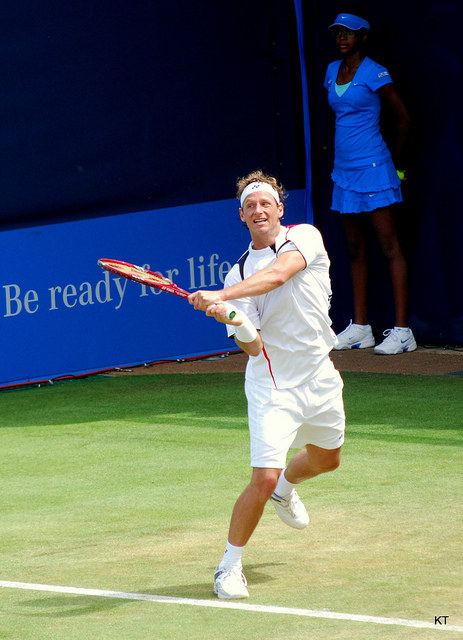

In [ ]:
print(train_captions[0])
Image.open(img_name_vector[0])

## InceptionV3

### Prepare image for InceptionV3

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)  # resize 299x299
    img = tf.keras.applications.inception_v3.preprocess_input(img)  # normalize img for InceptionV3
    return img, image_path

### Init InceptionV3 and create image features extractor model

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                 weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)  # image features extractor model

## Pre-process image and cache on disk

In [ ]:
def image_path_to_cache_path(path):
  """ Get cache linked to target image """
  image_name = path.split("/")[-1] + ".npy"
  return os.path.join(CACHE_FOLDER, image_name)

In [ ]:
CACHE_BATCH_SIZE = 16
encode_train = sorted(set(img_name_vector))  # get unique images

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(CACHE_BATCH_SIZE)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)  # get features
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))  # reshape in 2D

  for bf, p in zip(batch_features, path):
    path_of_feature = image_path_to_cache_path(p.numpy().decode("utf-8"))  # get path
    if not os.path.exists(path_of_feature):  #  if not already in cache
      np.save(path_of_feature, bf.numpy())  # save image features

## Tokenize caption

In [ ]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# Override the default standardization of TextVectorization to preserve
# "<>" characters, so preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    standardize=standardize,
    output_sequence_length=MAX_LENGTH)


tokenizer.adapt(caption_dataset)  # learn the vocabulary from the caption dataset

In [ ]:
# create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

### Save vocabulary from tokenizer

In [ ]:
pickle.dump(tokenizer.get_vocabulary(), open(VOCABULARY_PATH, "wb"))

## Split data into train and validation set

In [ ]:
img_to_cap_vector = collections.defaultdict(list)

for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

# split 80-20
slice_index = int(len(img_keys)*0.8)
img_name_train_keys = img_keys[:slice_index]  # 80% train
img_name_val_keys = img_keys[slice_index:]  # 20% val

# train set
img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

# val set
img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])
  

In [ ]:
# show train/val size
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(52035, 52035, 13005, 13005)

## Create tf.data to train data

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(img_name_train) // BATCH_SIZE

# Shape of the vector extracted from InceptionV3 is (64, 2048)
features_shape = 2048
attention_features_shape = 64

In [ ]:
# Load the numpy files (cache)
def map_func(img_name, cap):
  img_tensor = np.load(image_path_to_cache_path(img_name.decode('utf-8')))
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Model

### Bahdanau Attention
Full explanation : https://towardsdatascience.com/sequence-2-sequence-model-with-attention-mechanism-9e9ca2a613a

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    # Three dense layers to compute alignement score
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    """ 
    features = CNN_encoder's output (shape -> (batch_size, 64, embedding_dim) )
    hidden = current state from decoder (shape -> (batch_size, hidden_size) ) 
    """

    # hidden_with_time_axis.shape -> (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # This gives you an unnormalized score for each image feature
    score = self.V(attention_hidden_layer)  # calculate alignment score
    # score.shape -> (batch_size, 64, 1)

    
    # apply a softmax activation function to the alignment scores to obtain the attention weights
    attention_weights = tf.nn.softmax(score, axis=1)
     # attention_weights.shape -> (batch_size, 64, 1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

### Encoder

In [ ]:
class CNN_Encoder(tf.keras.layers.Layer):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    # And convert thoses features into two weights
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

### Decoder

In [ ]:
class RNN_Decoder(tf.keras.layers.Layer):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    # Gated Recurrent Unit
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    """ 
    x : current output of decoder
    features : output of encoder
    hidden : current state of decoder 
    """
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)  # predict next word

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    """ Reset decoder """
    return tf.zeros((batch_size, self.units))

### Captioner

In [ ]:
class Captioner(tf.keras.Model):
    embedding_dim = 256
    units = 512

    features_shape = 2048
    attention_features_shape = 64

    @staticmethod
    def load_image(image_path):
        img = tf.io.read_file(image_path)
        img = tf.io.decode_jpeg(img, channels=3)
        img = tf.keras.layers.Resizing(299, 299)(img)  # resize 299x299
        img = tf.keras.applications.inception_v3.preprocess_input(img)  # normalize img for InceptionV3
        return img, image_path

    def __init__(
            self,
            tokenizer_vocabulary,
            encoder=None,
            decoder=None,
            optimizer=None,
            max_caption_length=50
    ):
        super().__init__()

        self.vocabulary = tokenizer_vocabulary
        self.word_to_index = tf.keras.layers.StringLookup(
            mask_token="",
            vocabulary=self.vocabulary
        )
        self.index_to_word = tf.keras.layers.StringLookup(
            mask_token="",
            vocabulary=self.vocabulary,
            invert=True
        )

        self.max_caption_length = max_caption_length

        image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                        weights='imagenet')
        new_input = image_model.input
        hidden_layer = image_model.layers[-1].output

        self.image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

        self.encoder = encoder if encoder is not None else CNN_Encoder(self.embedding_dim)
        self.decoder = decoder if decoder is not None else RNN_Decoder(self.embedding_dim, self.units,
                                                                       len(self.vocabulary))
        self.optimizer = optimizer if optimizer is not None else tf.keras.optimizers.Adam()
        self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction='none')

        self.ckpt = tf.train.Checkpoint(encoder=self.encoder,
                                        decoder=self.decoder,
                                        optimizer=self.optimizer)
        self.ckpt_manager = tf.train.CheckpointManager(self.ckpt, CHECKPOINT_PATH, max_to_keep=5)


    def load_last_checkpoint(self):
        if self.ckpt_manager.latest_checkpoint:
            print(f"Restoring {self.ckpt_manager.latest_checkpoint.split('-')}")
            self.ckpt.restore(self.ckpt_manager.latest_checkpoint)

    def evaluate(self, image):
        """ Evaluate function """
        attention_plot = np.zeros((self.max_caption_length, self.attention_features_shape))

        hidden = self.decoder.reset_state(batch_size=1)

        temp_input = tf.expand_dims(self.load_image(image)[0], 0)
        img_tensor_val = self.image_features_extract_model(temp_input)
        img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                     -1,
                                                     img_tensor_val.shape[3]))

        features = self.encoder(img_tensor_val)

        dec_input = tf.expand_dims([self.word_to_index('<start>')], 0)
        result = []

        for i in range(self.max_caption_length):
            predictions, hidden, attention_weights = self.decoder(dec_input,
                                                                  features,
                                                                  hidden)

            attention_plot[i] = tf.reshape(attention_weights, (-1,)).numpy()

            predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
            predicted_word = tf.compat.as_text(self.index_to_word(predicted_id).numpy())
            result.append(predicted_word)

            if predicted_word == '<end>':
                return result, attention_plot

            dec_input = tf.expand_dims([predicted_id], 0)

        attention_plot = attention_plot[:len(result), :]
        return result, attention_plot

    def loss_function(self, real, pred):
        """ Calculate loss function """
        mask = tf.math.logical_not(tf.math.equal(real, 0))
        loss_ = self.loss_object(real, pred)

        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask

        return tf.reduce_mean(loss_)

    @tf.function
    def train_step(self, img_tensor, target):
        loss = 0

        # initializing the hidden state for each batch
        # because the captions are not related from image to image
        hidden = self.decoder.reset_state(batch_size=target.shape[0])

        dec_input = tf.expand_dims([self.word_to_index('<start>')] * target.shape[0], 1)

        with tf.GradientTape() as tape:
            features = self.encoder(img_tensor)

            for i in range(1, target.shape[1]):
                # passing the features through the decoder
                predictions, hidden, _ = self.decoder(dec_input, features, hidden)

                loss += self.loss_function(target[:, i], predictions)

                # using teacher forcing
                dec_input = tf.expand_dims(target[:, i], 1)

        total_loss = (loss / int(target.shape[1]))  # calculate loss

        # calculate gradient and apply to optimizer
        trainable_variables = self.encoder.trainable_variables + self.decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))

        return loss, total_loss


### Create captioner

In [ ]:
captioner = Captioner(tokenizer.get_vocabulary(), max_caption_length=MAX_LENGTH)

## Train

In [ ]:
loss_plot = []

In [ ]:
def display_and_save_loss(epoch):
  plt.plot(loss_plot)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss Plot')
  # plt.show()

  fig_name = f"{SAVEFIG_PATH}Loss_epoch{epoch}_size{LIMIT_SIZE}_batch{BATCH_SIZE}_buffer{BUFFER_SIZE}_time{time.time()}.png"
  plt.savefig(fig_name)

In [ ]:
start_epoch = 0
EPOCHS = 100

for epoch in range(start_epoch, EPOCHS):
    start = time.time()  # starting time
    print(f'Epoch {epoch+1} started at {datetime.now()}')
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = captioner.train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    
    loss_plot.append(total_loss / num_steps)  # storing the epoch end loss value to plot later

    if epoch % CHECKPOINT_EPOCH == 0:
      display_and_save_loss(epoch)
      captioner.ckpt_manager.save()  # save train progression

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for epoch {epoch+1} : {time.time()-start:.2f} sec\n')

In [ ]:
display_and_save_loss(epoch)

## Plot attention Function

In [ ]:
def plot_attention(image, result, attention_plot):
    """ Plot attention on image """
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

## Validation

Real Caption: <start> a bicycle rack with a bicycle chained to it on a sidewalk. <end>
Prediction Caption: a large silver train [UNK] with a bicycle chained to it on a street <end>


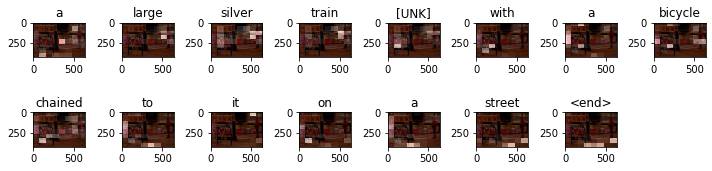

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(captioner.index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = captioner.evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

## Demonstration

In [ ]:
# captioner.load_last_checkpoint()  # load last checkpoint

Restoring ['/content/drive/MyDrive/Dataset/checkpoint/ckpt', '20']


Prediction Caption: a surfer is surfing a wave. <end>


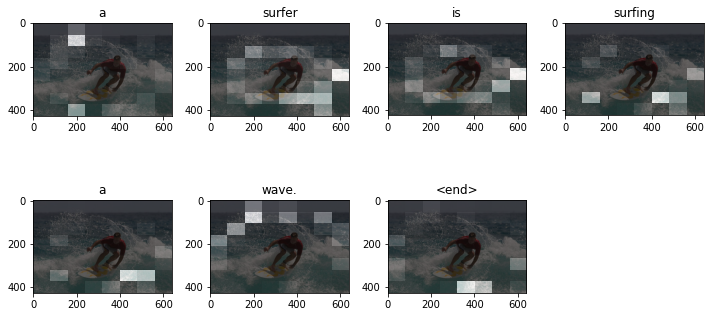

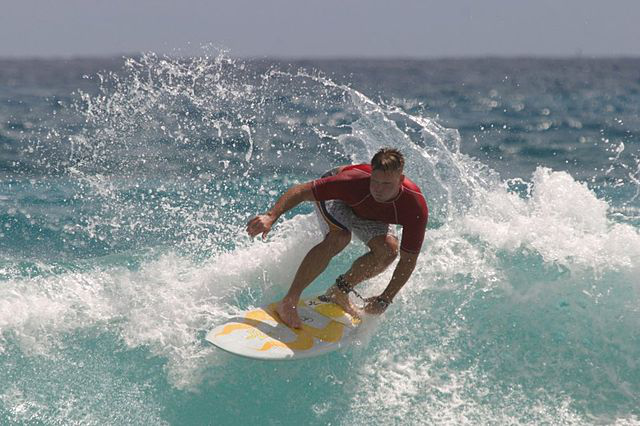

In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention = captioner.evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention)
# opening the image
Image.open(image_path)